In [ ]:
## Title: Get exon length - Figure S5C
## Input: outputs from scripts 1 and 3


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import mannwhitneyu



In [18]:
exons = pd.read_csv('whippet_CE_gene_name_exon_number.csv')
blocks = pd.read_csv('block_exons_ddPSImax0.2_adjacent.csv')
single = pd.read_csv('other_regulated_exons.csv')
sig_whip = pd.read_csv('sig_whip_CE_prob0.9_dPSI0.1.csv')

In [19]:
# Extract start and end coordinates
exons[['chr', 'start', 'end']] = exons['Coord'].str.extract(r'(chr[\dXY]+):(\d+)-(\d+)')

# Convert Start and End to integers
exons['start'] = exons['start'].astype(int)
exons['end'] = exons['end'].astype(int)

# Calculate exon length
exons['exon_length'] = exons['end'] - exons['start'] + 1  # +1 to include both start and end positions


In [20]:
exons.to_csv('whippet_CE_gene_name_exon_number_exon_length.csv')

In [26]:
# Count the number of unique genes in the 'Gene' column
num_unique_genes = exons['Gene'].nunique()

# Print the result
print(f"Number of unique genes: {num_unique_genes}")


Number of unique genes: 12895


In [23]:
# supsample exons dataframe, which contains length data for all

el_blocks = exons[exons['Coord'].isin(blocks['Coord'])].copy()
el_single = exons[exons['Coord'].isin(single['Coord'])].copy()

el_non_reg = exons[~exons['Coord'].isin(sig_whip['Coord'])].copy()

/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_37832/1166913850.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


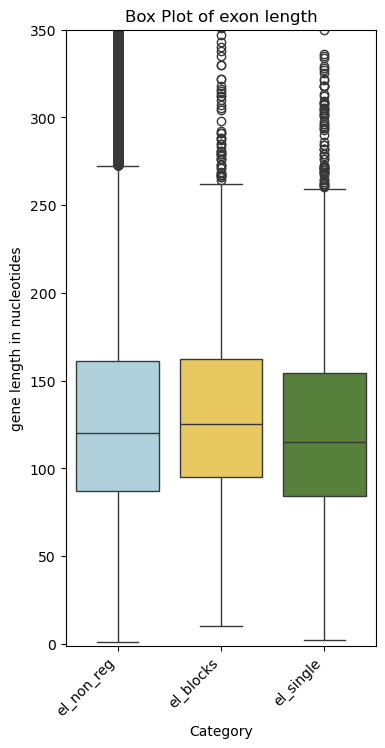

In [31]:
#### PLOT EXON LENGTH #####

# Define the custom color mapping
custom_colors = {
    "el_blocks": "#FFD449",  # Yellow
    "el_single": "#548C2F",  # Green
    "el_non_reg": "#A8D5E2",  # Blue
}

# Create a dictionary to store the gene_length dataframes
el_dataframes = {
    "el_non_reg": el_non_reg,
    "el_blocks": el_blocks,
    "el_single":el_single
}

# Create a list to store the data for plotting
plot_data = []

# Populate the plot_data list
for name, df in el_dataframes.items():
    if "exon_length" in df.columns:
        for value in df["exon_length"]:
            plot_data.append({"Category": name, "exon_length": value})

# Convert the list to a DataFrame
plot_df = pd.DataFrame(plot_data)


# Create the box plot
plt.figure(figsize=(4, 8))
sns.boxplot(
    x="Category",
    y="exon_length",
    data=plot_df,
    palette=[custom_colors[cat] for cat in plot_df["Category"].unique()]
)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")

# Add title and labels
plt.title("Box Plot of exon length")
plt.ylim(-1,350)
plt.xlabel("Category")
plt.ylabel("gene length in nucleotides")

plt.savefig('exon_length.pdf')

# Show the plot
plt.show()

In [30]:
# Extract exon length values for each category
exon_length_values = {
    name: df["exon_length"].dropna().values  # Drop NaN values if any
    for name, df in el_dataframes.items()
    if "exon_length" in df.columns
}

# List to store results
p_values = []

# Perform Mann-Whitney U test for each pair of categories
comparisons = list(combinations(exon_length_values.keys(), 2))  # List of all category pairs
num_tests = len(comparisons)  # Number of tests for Bonferroni correction

for (cat1, cat2) in comparisons:
    data1 = exon_length_values[cat1]
    data2 = exon_length_values[cat2]

    if len(data1) > 0 and len(data2) > 0:  # Ensure both categories have data
        stat, p = mannwhitneyu(data1, data2, alternative='two-sided')

        # Apply Bonferroni correction
        p_corrected = min(p * num_tests, 1.0)  # Ensure p-value does not exceed 1

        p_values.append({
            "Category 1": cat1, 
            "Category 2": cat2, 
            "Raw p-value": p, 
            "Bonferroni-corrected p-value": p_corrected
        })

# Convert results into a DataFrame
p_values_df = pd.DataFrame(p_values)

# Print the results
print(p_values_df)



   Category 1 Category 2   Raw p-value  Bonferroni-corrected p-value
0  el_non_reg  el_blocks  6.551279e-07                  1.965384e-06
1  el_non_reg  el_single  4.037032e-09                  1.211110e-08
2   el_blocks  el_single  1.439462e-15                  4.318387e-15
